### Nominal Nonlinear MPC

This notebook showcases the usage of a standard [nonlinear MPC controller](../ampyc/controllers/nonlinear_mpc.py). The accompanying notes for this notebook are [here](../notes/02_nominalMPC.pdf).

In [1]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# import the default parameters, the nonlinear system, and the nonlinear MPC controller
from ampyc.params import NonlinearMPCParams
from ampyc.systems import NonlinearSystem
from ampyc.controllers import NonlinearMPC

# import additional utilities from ampyc (plotting and RoA computation)
from ampyc.plotting import plot_x_state_time, plot_x_state_state, plot_u
from ampyc.utils import Polytope, compute_RoA

First, we instantiate the nonlinear system and the nonlinear MPC using the loaded default parameters

In [2]:
params = NonlinearMPCParams()
sys = NonlinearSystem(params.sys)
ctrl = NonlinearMPC(sys, params.ctrl)

Successfully initialized experiment 'nominal nonlinear MPC'.


Next, we simulate the nonlinear system with the nominal nonlinear MPC in the loop

In [3]:
# get the simulation parameters
num_steps = params.sim.num_steps
num_traj = 1 # only simulate one trajectory

# get the initial state from the parameters
x_0 = params.sim.x_0

# allocate state and input trajectories
x = np.zeros((num_steps+1, sys.n, num_traj))
u = np.zeros((num_steps, num_traj))
x[0,:,:] = x_0

# simulate the closed-loop system
for i in range(num_traj):
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_u, sol_x, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)

        # check if the solver returned an error message
        if error_msg != None:
            raise Exception(error_msg)
        
        # advance the system
        u[j,i] = sol_u[0]
        x[j+1,:,i] = sys.get_state(x[j,:,i], u[j,i]).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

Then, we can plot the closed-loop trajectories. We do this in angular coordinates, since the system we are simulating is a simplified segway model.

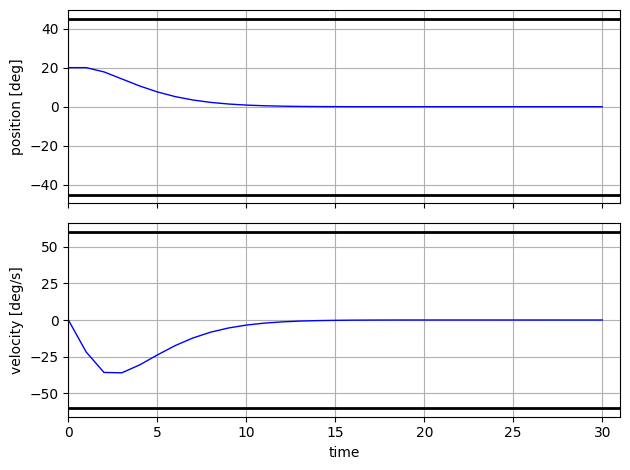

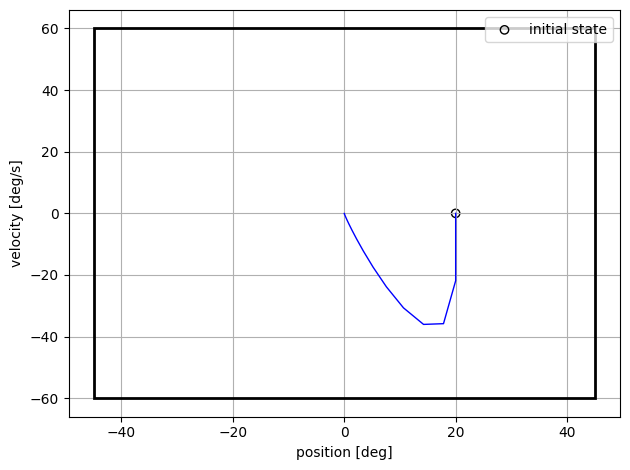

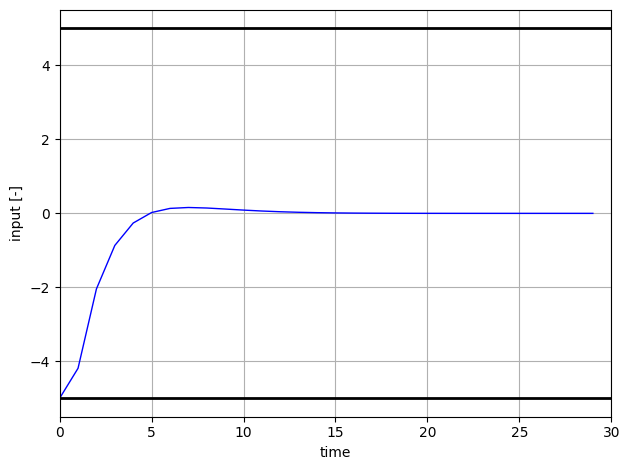

In [4]:
# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
X_deg = (180/np.pi) * sys.X

# plot the closed-loop state and input trajectories
plot_x_state_time(1, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_x_state_state(2, x_deg, X_deg, params.plot, axes_labels=['position [deg]', 'velocity [deg/s]'])
plot_u(3, u, sys.U, params.plot, axes_labels=['input [-]'])

Finally, we compute the region of attraction (RoA), i.e., the set of initial states for which the nonlinear MPC is feasible.

Note: Since computing the RoA will include solving the MPC for initial states close to infeasibility, you might encounter solver warnings regarding numerical inaccuracies. Here, these warnings can be safely ignored.

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


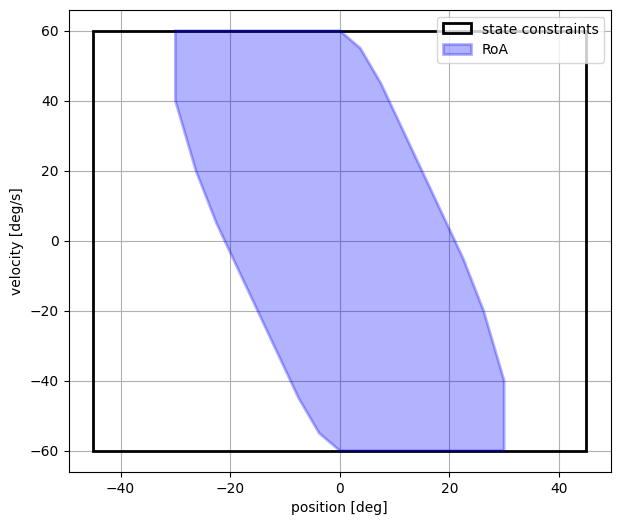

In [5]:
# NOTE: running this cell might take a while
_, ax = plt.subplots(1, 1, figsize=(7, 6))

# compute the RoA
RoA = compute_RoA(ctrl, sys)

# convert state constraints and RoA to degrees for plotting
X_deg = (180/np.pi) * sys.X
RoA = (180/np.pi) * RoA

# plot the RoA and the state constraints
X_deg.plot(ax=ax, fill=False, color='black', alpha=1.0, linewidth=2, label='state constraints')
RoA.plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2, label='RoA')

# set the axis labels and limits
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)

# add a grid and the legend
plt.grid()
plt.legend(loc="upper right")
plt.show()

### Robustness of nominal nonlinear MPC
Next, we investigate the robustness of the nominal nonlinear MPC controller without any dedicated robust design. To do this, we first reset the noise generator of the system to increase the disturbance acting on the system.

In [6]:
# so far we have used zero noise. We can check this by printing the noise generator's vertices
sys.noise_generator.V

array([[ 0., -0.],
       [ 0.,  0.],
       [-0.,  0.],
       [-0., -0.]])

In [7]:
# reset the noise generator with a larger disturbance polytope
b_w = np.array([0.3, 0.3, 1e-6, 1e-6]).reshape(-1,1)
A_w = params.sys.A_w
params.sys.noise_generator.reset(Polytope(A_w, b_w))

# reinitialize the nonlinear system with the new parameters
unc_sys = NonlinearSystem(params.sys)

In [8]:
# we can also check the new noise generator's vertices
unc_sys.noise_generator.V

array([[ 0.3, -0. ],
       [ 0.3,  0. ],
       [-0.3,  0. ],
       [-0.3, -0. ]])

Next, we check various initial states to see if the closed-loop trajectories become infeasible

In [9]:
# NOTE: running this cell might take a while

# set random seed for reproducibility
unc_sys.noise_generator.seed(42)

# create a grid of initial conditions within the state constraints
GRID_SIZE = 15
grid = unc_sys.X.grid(GRID_SIZE**2)
x_0 = grid.reshape(GRID_SIZE**2,2).T

# obtain simulation parameters 
num_steps = params.sim.num_steps
num_traj = x_0.shape[1]

# allocate state trajectories
x = np.empty((num_steps+1,) + x_0.shape)
x[:] = np.nan

# simulate the closed-loop
for i in range(num_traj):
    # set initial condition
    x[0,:,i] = x_0[:,i]
    for j in range(num_steps):
        # get the control input by solving the MPC problem
        sol_u, sol_x, error_msg = ctrl.solve(x[j,:,i], additional_parameters={}, verbose=False)

        # check if the solver returned an error message
        if error_msg != None:
            break

        # if the solver was successful, advance the system
        u = sol_u[0]
        x[j+1,:,i] = unc_sys.get_state(x[j,:,i], u).reshape(-1) # here we directly use the get_state method, since the output equation is the identity

Then, we can plot the closed-loop trajectories, highlighting the trajectories that become unstable during operation

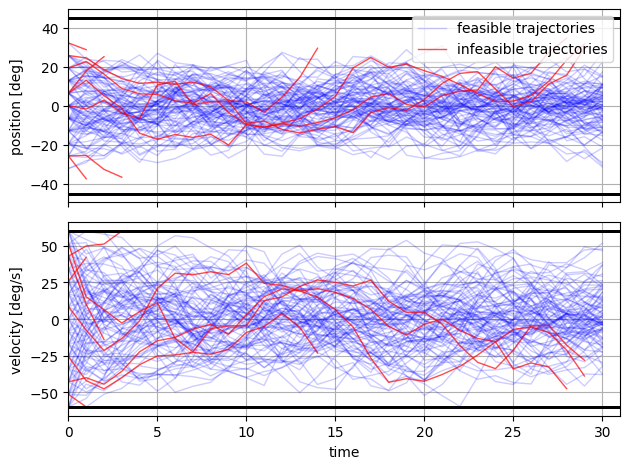

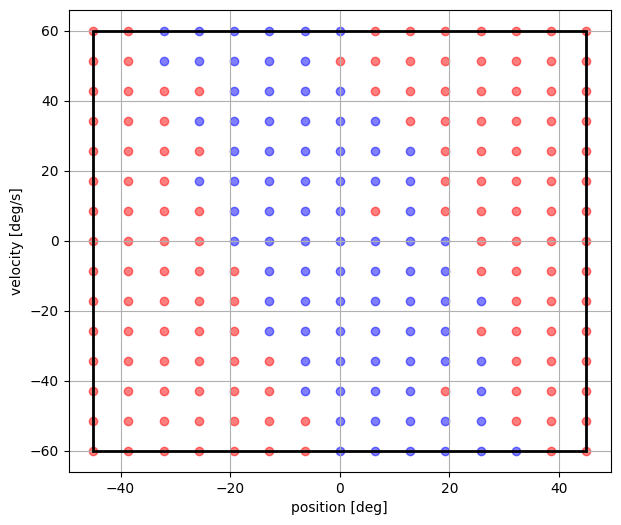

In [10]:
# identify unstable trajectories
infeas_traj = np.zeros(num_traj, dtype=bool)
for i in range(num_traj):
    if np.any(np.isnan(x[:,:,i])):
        infeas_traj[i] = True

# convert the state trajectory and the state constraints to degrees for plotting
x_deg = np.rad2deg(x)
x_0_deg = np.rad2deg(x_0)
X_deg = (180/np.pi) * unc_sys.X

# plot stable state trajectories
params.plot.color = 'blue' # ensure that feasible trajectories are plotted in blue (in case of rerunning the cell)
params.plot.alpha = 0.2
plot_x_state_time(1, x_deg[:,:,~infeas_traj], X_deg, params.plot, label='feasible trajectories', axes_labels=['position [deg]', 'velocity [deg/s]'])

# highlight unstable state trajectories
params.plot.color = 'red' # use red for infeasible trajectories
params.plot.alpha = 0.7
plot_x_state_time(1, x_deg[:,:,infeas_traj], X_deg, params.plot, label='infeasible trajectories', axes_labels=['position [deg]', 'velocity [deg/s]'])

# plot which initial conditions resulted in feasible or infeasible trajectories
_, ax = plt.subplots(1, 1, figsize=(7, 6))
X_deg.plot(ax, fill=False, color='black', alpha=1, linewidth=2, label='state constraints')
ax.scatter(x_0_deg[0,~infeas_traj], x_0_deg[1,~infeas_traj], color='blue', alpha=0.5, label='feasible')
ax.scatter(x_0_deg[0,infeas_traj], x_0_deg[1,infeas_traj], color='red', alpha=0.5, label='infeasible')
ax.set_xlim(X_deg.xlim)
ax.set_ylim(X_deg.ylim)
ax.set_xlabel('position [deg]')
ax.set_ylabel('velocity [deg/s]')
plt.grid()
plt.show()

Note that here the set of feasible initial states (region of attraction) contains some "holes", since nominal nonlinear MPC has no robust design. You can play around with the size of the disturbance polytope used in the cells above, to see how nominal nonlinear MPC behaves for different disturbance levels.